## Лабораторная работа №2

Выполнила: Кудаева Вика М8О-310Б-23

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.interpolate import interp1d
import warnings
import inspect
from copy import deepcopy
import time

from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, average_precision_score, confusion_matrix, 
                           classification_report, roc_curve, precision_recall_curve)
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

import optuna

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

### Загрузка данных

In [34]:
train_df = pd.read_csv('train_c.csv')
test_df = pd.read_csv('test_c.csv')

print(f"Размер обучающей выборки: {train_df.shape}")
print(f"Размер тестовой выборки: {test_df.shape}")
print()

print("Первые 5 строк обучающей выборки:")
print(train_df.head())
print()

print("Информация о данных:")
print(train_df.info())
print()

Размер обучающей выборки: (11017, 35)
Размер тестовой выборки: (5000, 35)

Первые 5 строк обучающей выборки:
  ApplicationDate   Age  AnnualIncome  CreditScore  LoanAmount  LoanDuration  \
0      2010-06-26  27.0       66829.0        549.0     17290.0          60.0   
1      1996-09-23  55.0      172147.0        850.0     16110.0          36.0   
2      2015-01-19  51.0      300000.0        850.0     38436.0          36.0   
3      1981-05-12  25.0       34683.0        847.0     19186.0          48.0   
4      1995-05-07  55.0      300000.0        850.0     30437.0          48.0   

  MaritalStatus  NumberOfDependents HomeOwnershipStatus  MonthlyDebtPayments  \
0      Divorced                 1.0                Rent               1095.0   
1       Widowed                 1.0            Mortgage                211.0   
2       Married                 0.0            Mortgage                546.0   
3       Married                 0.0               Other                153.0   
4        S

### EDA


1. АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
----------------------------------------
                            Количество пропусков  Процент пропусков
TotalAssets                                 1031           9.358265
CreditScore                                 1031           9.358265
LoanAmount                                  1031           9.358265
BaseInterestRate                            1031           9.358265
NetWorth                                    1031           9.358265
MonthlyDebtPayments                         1031           9.358265
CheckingAccountBalance                      1031           9.358265
LoanPurpose                                 1031           9.358265
BankruptcyHistory                           1031           9.358265
JobTenure                                    530           4.810747
TotalLiabilities                             530           4.810747
MonthlyIncome                                530           4.810747
UtilityBillsPaymentHistory                 

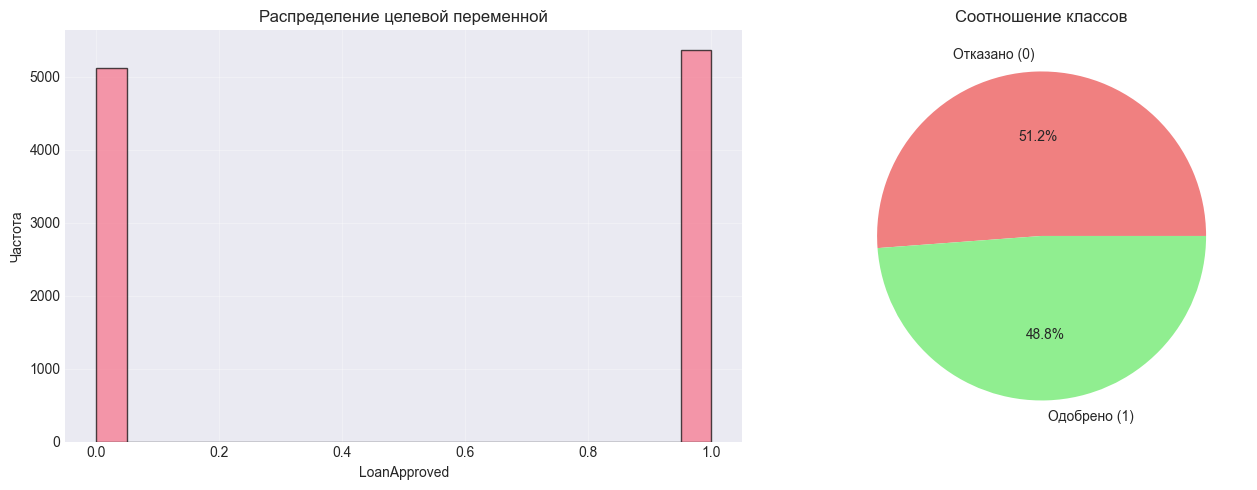

Статистика по целевой переменной:
Всего записей: 11017
Класс 0 (Отказано): 5120 (46.5%)
Класс 1 (Одобрено): 5367 (48.7%)
Баланс классов: Сбалансирован


3. ГРАФИКИ ЗАВИСИМОСТИ ПРИЗНАКОВ
----------------------------------------


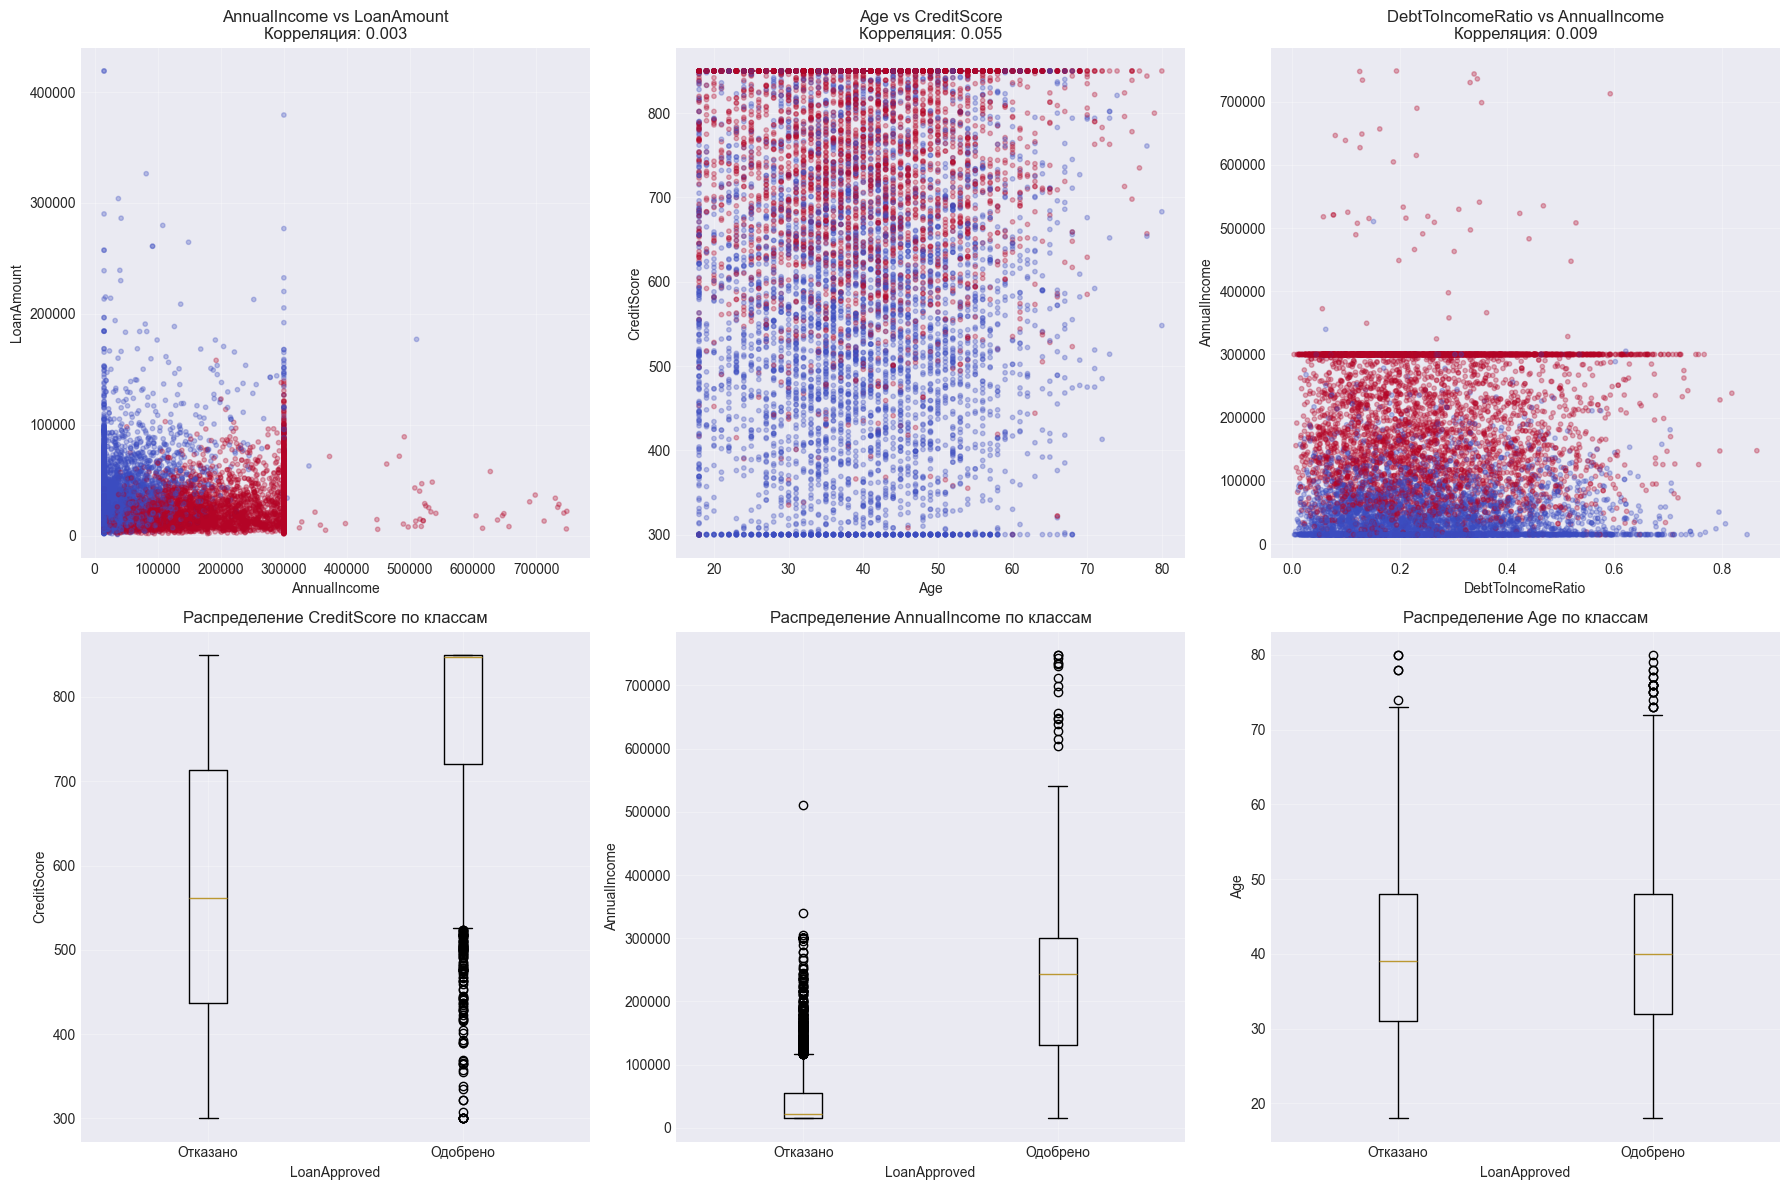


4. МАТРИЦА КОРРЕЛЯЦИЙ
----------------------------------------


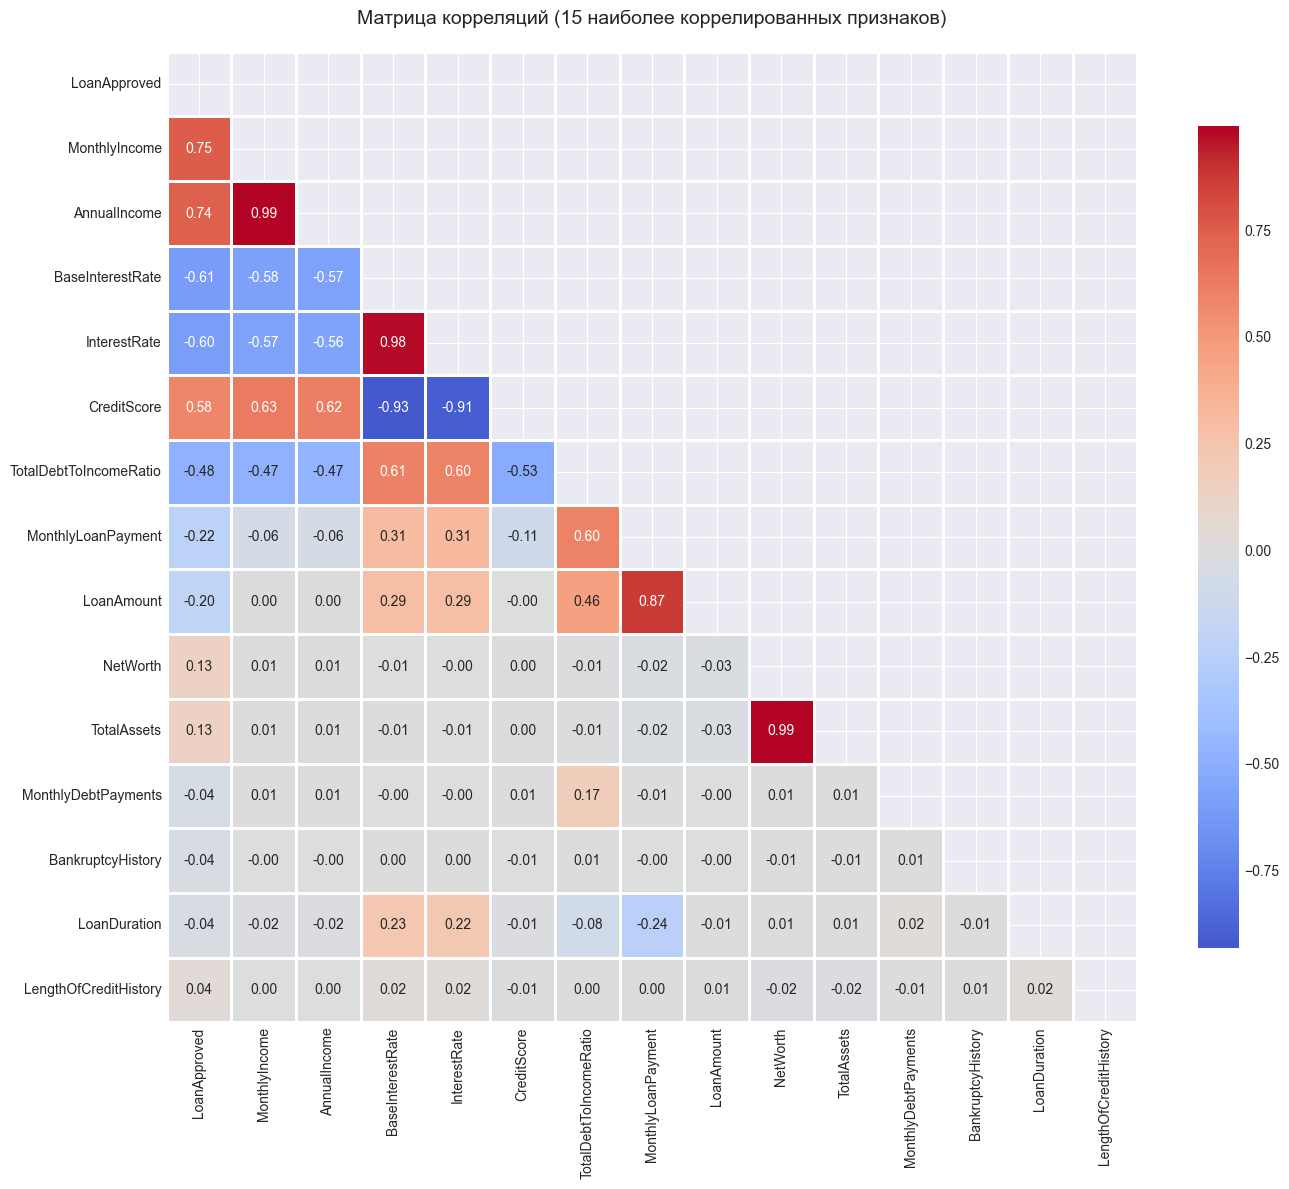

In [36]:
print("\n1. АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ")
print("-" * 40)

missing_values = train_df.isnull().sum()
missing_percent = (missing_values / len(train_df)) * 100
missing_df = pd.DataFrame({
    'Количество пропусков': missing_values,
    'Процент пропусков': missing_percent
})
print(missing_df[missing_df['Количество пропусков'] > 0].sort_values('Процент пропусков', ascending=False))
print()

print("\n2. АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ LoanApproved")
print("-" * 40)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(train_df['LoanApproved'], bins=20, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('LoanApproved')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение целевой переменной')
axes[0].grid(True, alpha=0.3)

class_counts = train_df['LoanApproved'].value_counts()
axes[1].pie(class_counts.values, labels=['Отказано (0)', 'Одобрено (1)'], 
           autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
axes[1].set_title('Соотношение классов')

plt.tight_layout()
plt.show()

print("Статистика по целевой переменной:")
print(f"Всего записей: {len(train_df)}")
print(f"Класс 0 (Отказано): {class_counts[0]} ({class_counts[0]/len(train_df)*100:.1f}%)")
print(f"Класс 1 (Одобрено): {class_counts[1]} ({class_counts[1]/len(train_df)*100:.1f}%)")
print(f"Баланс классов: {'Сбалансирован' if abs(class_counts[0] - class_counts[1])/len(train_df) < 0.1 else 'Несбалансирован'}")
print()

print("\n3. ГРАФИКИ ЗАВИСИМОСТИ ПРИЗНАКОВ")
print("-" * 40)

key_features = ['AnnualIncome', 'Age', 'CreditScore', 'LoanAmount', 'DebtToIncomeRatio', 'LoanApproved']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

pairs = [
    ('AnnualIncome', 'LoanAmount'),
    ('Age', 'CreditScore'),
    ('DebtToIncomeRatio', 'AnnualIncome'),
    ('CreditScore', 'LoanApproved'),
    ('AnnualIncome', 'LoanApproved'),
    ('Age', 'LoanApproved')
]

for i, (x_feature, y_feature) in enumerate(pairs):
    if x_feature in train_df.columns and y_feature in train_df.columns:
        axes[i].scatter(train_df[x_feature], train_df[y_feature], 
                       alpha=0.3, s=10, c=train_df['LoanApproved'], cmap='coolwarm')
        axes[i].set_xlabel(x_feature)
        axes[i].set_ylabel(y_feature)
        
        if y_feature == 'LoanApproved':
            data = [train_df[train_df['LoanApproved'] == 0][x_feature].dropna(),
                   train_df[train_df['LoanApproved'] == 1][x_feature].dropna()]
            axes[i].clear()
            axes[i].boxplot(data, labels=['Отказано', 'Одобрено'])
            axes[i].set_xlabel('LoanApproved')
            axes[i].set_ylabel(x_feature)
            axes[i].set_title(f'Распределение {x_feature} по классам')
        else:
            correlation = train_df[x_feature].corr(train_df[y_feature])
            axes[i].set_title(f'{x_feature} vs {y_feature}\nКорреляция: {correlation:.3f}')
        
        axes[i].grid(True, alpha=0.3)
    else:
        axes[i].text(0.5, 0.5, f'Признак отсутствует\n{x_feature} или {y_feature}', 
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(f'{x_feature} vs {y_feature}')
        axes[i].axis('off')

plt.tight_layout()
plt.show()

print("\n4. МАТРИЦА КОРРЕЛЯЦИЙ")
print("-" * 40)

numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
if 'LoanApproved' in numeric_cols:
    correlation_with_target = train_df[numeric_cols].corr()['LoanApproved'].abs().sort_values(ascending=False)
    top_features = correlation_with_target.index[:15]
    
    plt.figure(figsize=(14, 12))
    corr_matrix = train_df[top_features].corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Матрица корреляций (15 наиболее коррелированных признаков)', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

### Предобработка данных

In [41]:
def preprocess_data_with_reduction(train_df, test_df, n_features=100):
    train_processed = train_df.copy()
    test_processed = test_df.copy()
    
    print(f"1. Удаление пропусков в целевой переменной:")
    print(f"   До удаления: {len(train_processed)} строк")
    train_processed = train_processed.dropna(subset=['LoanApproved'])
    print(f"   После удаления: {len(train_processed)} строк")
    
    X_train = train_processed.drop('LoanApproved', axis=1)
    y_train = train_processed['LoanApproved']
    X_test = test_processed
    
    print(f"\n2. Проверка целевой переменной:")
    print(f"   Пропуски в y_train: {y_train.isnull().sum()}")
    
    if 'ID' in X_train.columns:
        X_train = X_train.drop('ID', axis=1)
    if 'ID' in X_test.columns:
        test_ids = X_test['ID']
        X_test = X_test.drop('ID', axis=1)
    else:
        test_ids = pd.Series(range(len(X_test)), name='ID')
    
    numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
    
    print(f"\n3. Анализ признаков:")
    print(f"   Числовые признаки: {len(numeric_features)}")
    print(f"   Категориальные признаки: {len(categorical_features)}")
    
    print(f"\n4. Заполнение пропущенных значений...")
    
    num_imputer = SimpleImputer(strategy='median')
    X_train[numeric_features] = num_imputer.fit_transform(X_train[numeric_features])
    X_test[numeric_features] = num_imputer.transform(X_test[numeric_features])
    
    if categorical_features:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        X_train[categorical_features] = cat_imputer.fit_transform(X_train[categorical_features])
        X_test[categorical_features] = cat_imputer.transform(X_test[categorical_features])
    
    print(f"\n5. Кодирование категориальных признаков (Label Encoding):")
    
    if categorical_features:
        from sklearn.preprocessing import LabelEncoder
        
        for col in categorical_features:
            le = LabelEncoder()
            combined = pd.concat([X_train[col], X_test[col]], axis=0)
            le.fit(combined)
            
            X_train[col] = le.transform(X_train[col])
            X_test[col] = le.transform(X_test[col])
        
        print(f"   Все признаки после кодирования: {X_train.shape[1]}")
    
    print(f"\n6. Масштабирование признаков...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    
    print(f"\n7. Отбор {n_features} лучших признаков...")
    
    total_features = X_train.shape[1]
    if total_features > n_features:
        selector = SelectKBest(score_func=f_classif, k=n_features)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)
        
        selected_features = X_train.columns[selector.get_support()].tolist()
        
        X_train = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train.index)
        X_test = pd.DataFrame(X_test_selected, columns=selected_features, index=X_test.index)
        
        print(f"   Отобрано {len(selected_features)} признаков из {total_features}")
    else:
        print(f"   Количество признаков ({total_features}) меньше или равно {n_features}, отбор не требуется")
    
    print(f"\n8. Итоговый размер:")
    print(f"   Обучающая выборка: {X_train.shape}")
    print(f"   Тестовая выборка: {X_test.shape}")
    
    return X_train, y_train, X_test, test_ids

X_train, y_train, X_test, test_ids = preprocess_data_with_reduction(
    train_df, test_df, n_features=100
)

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"\n9. Разделение на train/validation:")
print(f"   Train: {X_train_split.shape}")
print(f"   Validation: {X_val_split.shape}")

1. Удаление пропусков в целевой переменной:
   До удаления: 11017 строк
   После удаления: 10487 строк

2. Проверка целевой переменной:
   Пропуски в y_train: 0

3. Анализ признаков:
   Числовые признаки: 28
   Категориальные признаки: 6

4. Заполнение пропущенных значений...

5. Кодирование категориальных признаков (Label Encoding):
   Все признаки после кодирования: 34

6. Масштабирование признаков...

7. Отбор 100 лучших признаков...
   Количество признаков (34) меньше или равно 100, отбор не требуется

8. Итоговый размер:
   Обучающая выборка: (10487, 34)
   Тестовая выборка: (5000, 34)

9. Разделение на train/validation:
   Train: (8389, 34)
   Validation: (2098, 34)


### Реализация метрик

In [42]:
class CustomMetrics:
    
    @staticmethod
    def confusion_matrix(y_true, y_pred):
        tp = np.sum((y_true == 1) & (y_pred == 1))
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        return tp, tn, fp, fn
    
    @staticmethod
    def accuracy(y_true, y_pred):
        tp, tn, fp, fn = CustomMetrics.confusion_matrix(y_true, y_pred)
        return (tp + tn) / (tp + tn + fp + fn + 1e-10)
    
    @staticmethod
    def precision(y_true, y_pred):
        tp, tn, fp, fn = CustomMetrics.confusion_matrix(y_true, y_pred)
        return tp / (tp + fp + 1e-10)
    
    @staticmethod
    def recall(y_true, y_pred):
        tp, tn, fp, fn = CustomMetrics.confusion_matrix(y_true, y_pred)
        return tp / (tp + fn + 1e-10)
    
    @staticmethod
    def f1_score(y_true, y_pred):
        precision = CustomMetrics.precision(y_true, y_pred)
        recall = CustomMetrics.recall(y_true, y_pred)
        return 2 * precision * recall / (precision + recall + 1e-10)
    
    @staticmethod
    def roc_auc(y_true, y_pred_proba):
        sorted_indices = np.argsort(y_pred_proba)[::-1]
        y_true_sorted = y_true.iloc[sorted_indices] if hasattr(y_true, 'iloc') else y_true[sorted_indices]
        y_pred_proba_sorted = y_pred_proba[sorted_indices]
        
        thresholds = np.unique(y_pred_proba_sorted)[::-1]
        tpr_list = []
        fpr_list = []
        
        tpr_list.append(0)
        fpr_list.append(0)
        
        for threshold in thresholds:
            y_pred = (y_pred_proba_sorted >= threshold).astype(int)
            tp = np.sum((y_true_sorted == 1) & (y_pred == 1))
            fn = np.sum((y_true_sorted == 1) & (y_pred == 0))
            fp = np.sum((y_true_sorted == 0) & (y_pred == 1))
            tn = np.sum((y_true_sorted == 0) & (y_pred == 0))
            
            tpr = tp / (tp + fn + 1e-10)
            fpr = fp / (fp + tn + 1e-10)
            
            tpr_list.append(tpr)
            fpr_list.append(fpr)
        
        tpr_list.append(1)
        fpr_list.append(1)
        
        auc = 0
        for i in range(1, len(fpr_list)):
            auc += (fpr_list[i] - fpr_list[i-1]) * (tpr_list[i] + tpr_list[i-1]) / 2
        
        return auc, tpr_list, fpr_list
    
    @staticmethod
    def pr_auc(y_true, y_pred_proba):
        sorted_indices = np.argsort(y_pred_proba)[::-1]
        y_true_sorted = y_true.iloc[sorted_indices] if hasattr(y_true, 'iloc') else y_true[sorted_indices]
        y_pred_proba_sorted = y_pred_proba[sorted_indices]
        
        thresholds = np.unique(y_pred_proba_sorted)[::-1]
        precision_list = []
        recall_list = []
        
        precision_list.append(1)
        recall_list.append(0)
        
        tp_cum = 0
        fp_cum = 0
        total_positives = np.sum(y_true_sorted == 1)
        
        for i, threshold in enumerate(thresholds):
            y_pred = (y_pred_proba_sorted >= threshold).astype(int)
            
            tp = np.sum((y_true_sorted == 1) & (y_pred == 1))
            fp = np.sum((y_true_sorted == 0) & (y_pred == 1))
            
            precision = tp / (tp + fp + 1e-10)
            recall = tp / (total_positives + 1e-10)
            
            precision_list.append(precision)
            recall_list.append(recall)
        
        auc_pr = 0
        for i in range(1, len(recall_list)):
            auc_pr += (recall_list[i] - recall_list[i-1]) * (precision_list[i] + precision_list[i-1]) / 2
        
        return auc_pr, precision_list, recall_list

### Тестирование реализованных метрик

In [43]:
y_test_true = np.array([1, 0, 1, 1, 0, 0, 1, 0, 1, 0])
y_test_pred = np.array([1, 0, 0, 1, 1, 0, 1, 0, 0, 0])
y_test_proba = np.array([0.9, 0.1, 0.4, 0.8, 0.6, 0.2, 0.7, 0.3, 0.45, 0.25])

custom_acc = CustomMetrics.accuracy(y_test_true, y_test_pred)
custom_prec = CustomMetrics.precision(y_test_true, y_test_pred)
custom_rec = CustomMetrics.recall(y_test_true, y_test_pred)
custom_f1 = CustomMetrics.f1_score(y_test_true, y_test_pred)
custom_auc, _, _ = CustomMetrics.roc_auc(y_test_true, y_test_proba)
custom_auc_pr, _, _ = CustomMetrics.pr_auc(y_test_true, y_test_proba)

sklearn_acc = accuracy_score(y_test_true, y_test_pred)
sklearn_prec = precision_score(y_test_true, y_test_pred)
sklearn_rec = recall_score(y_test_true, y_test_pred)
sklearn_f1 = f1_score(y_test_true, y_test_pred)
sklearn_auc = roc_auc_score(y_test_true, y_test_proba)
sklearn_auc_pr = average_precision_score(y_test_true, y_test_proba)

print(f"{'Метрика':<15} {'Custom':<10} {'Sklearn':<10} {'Разница':<10}")
print("-" * 45)
print(f"{'Accuracy':<15} {custom_acc:<10.4f} {sklearn_acc:<10.4f} {abs(custom_acc - sklearn_acc):<10.4f}")
print(f"{'Precision':<15} {custom_prec:<10.4f} {sklearn_prec:<10.4f} {abs(custom_prec - sklearn_prec):<10.4f}")
print(f"{'Recall':<15} {custom_rec:<10.4f} {sklearn_rec:<10.4f} {abs(custom_rec - sklearn_rec):<10.4f}")
print(f"{'F1-Score':<15} {custom_f1:<10.4f} {sklearn_f1:<10.4f} {abs(custom_f1 - sklearn_f1):<10.4f}")
print(f"{'ROC-AUC':<15} {custom_auc:<10.4f} {sklearn_auc:<10.4f} {abs(custom_auc - sklearn_auc):<10.4f}")
print(f"{'PR-AUC':<15} {custom_auc_pr:<10.4f} {sklearn_auc_pr:<10.4f} {abs(custom_auc_pr - sklearn_auc_pr):<10.4f}")

Метрика         Custom     Sklearn    Разница   
---------------------------------------------
Accuracy        0.7000     0.7000     0.0000    
Precision       0.7500     0.7500     0.0000    
Recall          0.6000     0.6000     0.0000    
F1-Score        0.6667     0.6667     0.0000    
ROC-AUC         0.9200     0.9200     0.0000    
PR-AUC          0.9183     0.9267     0.0083    


### Класс бэггинга

In [44]:
class CustomBaggingClassifier:
    
    def __init__(self, base_estimator=None, n_estimators=10, 
                 max_samples=1.0, max_features=1.0,
                 bootstrap=True, bootstrap_features=False,
                 random_state=None, verbose=0):
        self.base_estimator = base_estimator if base_estimator else DecisionTreeClassifier(max_depth=5)
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.bootstrap_features = bootstrap_features
        self.random_state = random_state
        self.verbose = verbose
        
        self.estimators_ = []
        self.estimator_features_ = []
        self.n_features_ = None
        
        if random_state is not None:
            np.random.seed(random_state)
    
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        
        n_samples, self.n_features_ = X.shape
        n_samples_bootstrap = int(self.max_samples * n_samples)
        n_features_bootstrap = int(self.max_features * self.n_features_)
        
        self.estimators_ = []
        self.estimator_features_ = []
        
        for i in range(self.n_estimators):
            if self.verbose > 0 and i % 10 == 0:
                print(f"Обучение модели {i+1}/{self.n_estimators}")
            
            if self.bootstrap:
                sample_indices = np.random.choice(n_samples, n_samples_bootstrap, replace=True)
            else:
                sample_indices = np.random.choice(n_samples, n_samples_bootstrap, replace=False)
            
            if self.bootstrap_features:
                feature_indices = np.random.choice(self.n_features_, n_features_bootstrap, replace=True)
            else:
                feature_indices = np.random.choice(self.n_features_, n_features_bootstrap, replace=False)
            
            X_bootstrap = X[np.ix_(sample_indices, feature_indices)]
            y_bootstrap = y[sample_indices]
            
            estimator = clone(self.base_estimator)
            estimator.fit(X_bootstrap, y_bootstrap)
            
            self.estimators_.append(estimator)
            self.estimator_features_.append(feature_indices)
        
        return self
    
    def predict_proba(self, X):
        X = np.array(X)
        n_samples = X.shape[0]
        
        all_proba = np.zeros((n_samples, 2))
        
        for i, (estimator, feature_indices) in enumerate(zip(self.estimators_, self.estimator_features_)):
            X_subset = X[:, feature_indices]
            proba = estimator.predict_proba(X_subset)
            all_proba += proba
        
        return all_proba / self.n_estimators
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

### Тестирование бэггинга

In [45]:
base_estimator = DecisionTreeClassifier(max_depth=5, random_state=42)
custom_bagging = CustomBaggingClassifier(
    base_estimator=base_estimator,
    n_estimators=20,
    max_samples=0.8,
    max_features=0.8,
    bootstrap=True,
    random_state=42,
    verbose=1
)

start_time = time.time()
custom_bagging.fit(X_train_split.values, y_train_split.values)
custom_bagging_time = time.time() - start_time

y_pred_custom_bagging = custom_bagging.predict(X_val_split.values)
y_pred_proba_custom_bagging = custom_bagging.predict_proba(X_val_split.values)[:, 1]

custom_bagging_acc = accuracy_score(y_val_split, y_pred_custom_bagging)
custom_bagging_auc = roc_auc_score(y_val_split, y_pred_proba_custom_bagging)

print(f"\nРезультаты кастомного бэггинга:")
print(f"  Время обучения: {custom_bagging_time:.2f} сек")
print(f"  Accuracy: {custom_bagging_acc:.4f}")
print(f"  ROC-AUC: {custom_bagging_auc:.4f}")

print("\nСравнение с sklearn BaggingClassifier:")

sklearn_bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5, random_state=42),
    n_estimators=20,
    max_samples=0.8,
    max_features=0.8,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
sklearn_bagging.fit(X_train_split, y_train_split)
sklearn_bagging_time = time.time() - start_time

y_pred_sklearn_bagging = sklearn_bagging.predict(X_val_split)
y_pred_proba_sklearn_bagging = sklearn_bagging.predict_proba(X_val_split)[:, 1]

sklearn_bagging_acc = accuracy_score(y_val_split, y_pred_sklearn_bagging)
sklearn_bagging_auc = roc_auc_score(y_val_split, y_pred_proba_sklearn_bagging)

print(f"\nРезультаты sklearn бэггинга:")
print(f"  Время обучения: {sklearn_bagging_time:.2f} сек")
print(f"  Accuracy: {sklearn_bagging_acc:.4f}")
print(f"  ROC-AUC: {sklearn_bagging_auc:.4f}")

print(f"\nРазница в метриках:")
print(f"  Accuracy разница: {abs(custom_bagging_acc - sklearn_bagging_acc):.6f}")
print(f"  ROC-AUC разница: {abs(custom_bagging_auc - sklearn_bagging_auc):.6f}")


Обучение модели 1/20
Обучение модели 11/20

Результаты кастомного бэггинга:
  Время обучения: 1.59 сек
  Accuracy: 0.9180
  ROC-AUC: 0.9755

Сравнение с sklearn BaggingClassifier:

Результаты sklearn бэггинга:
  Время обучения: 4.75 сек
  Accuracy: 0.9156
  ROC-AUC: 0.9749

Разница в метриках:
  Accuracy разница: 0.002383
  ROC-AUC разница: 0.000620


### Класс градиентного бустинга

In [46]:
class CustomGradientBoostingClassifier:
    
    def __init__(self, n_estimators=100, learning_rate=0.1, 
                 max_depth=3, min_samples_split=2,
                 subsample=1.0, random_state=None, verbose=0):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.subsample = subsample
        self.random_state = random_state
        self.verbose = verbose
        
        self.trees_ = []
        self.initial_prediction_ = None
        
        if random_state is not None:
            np.random.seed(random_state)
    
    @staticmethod
    def _sigmoid(x):
        x = np.clip(x, -20, 20)
        return 1 / (1 + np.exp(-x))
    
    def _log_loss_gradient(self, y_true, y_pred_log_odds):
        p = self._sigmoid(y_pred_log_odds)
        return p - y_true
    
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y).astype(float)
        
        n_samples = X.shape[0]
        
        pos_class_ratio = np.mean(y)
        pos_class_ratio = np.clip(pos_class_ratio, 1e-10, 1 - 1e-10)
        self.initial_prediction_ = np.log(pos_class_ratio / (1 - pos_class_ratio))
        current_predictions = np.full(n_samples, self.initial_prediction_, dtype=float)
        
        self.trees_ = []
        
        for i in range(self.n_estimators):
            if self.verbose > 0 and i % 10 == 0:
                print(f"Обучение дерева {i+1}/{self.n_estimators}")
            
            pseudo_residuals = self._log_loss_gradient(y, current_predictions)
            
            if self.subsample < 1.0:
                subsample_size = int(self.subsample * n_samples)
                indices = np.random.choice(n_samples, subsample_size, replace=False)
                X_subset = X[indices]
                residuals_subset = pseudo_residuals[indices]
            else:
                indices = np.arange(n_samples)
                X_subset = X
                residuals_subset = pseudo_residuals
            
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                random_state=self.random_state
            )
            
            tree.fit(X_subset, residuals_subset)
            
            if self.subsample < 1.0:
                tree_predictions = tree.predict(X)
            else:
                tree_predictions = tree.predict(X_subset)
            
            current_predictions -= self.learning_rate * tree_predictions
            
            self.trees_.append(tree)
            
            if self.verbose > 1 and i % 10 == 0:
                current_proba = self._sigmoid(current_predictions)
                current_loss = -np.mean(y * np.log(current_proba + 1e-10) + 
                                      (1 - y) * np.log(1 - current_proba + 1e-10))
                print(f"  Loss: {current_loss:.4f}")
        
        return self
    
    def predict_proba(self, X):
        X = np.array(X)
        
        predictions = np.full(X.shape[0], self.initial_prediction_, dtype=float)
        
        for tree in self.trees_:
            predictions -= self.learning_rate * tree.predict(X)
        
        proba_positive = self._sigmoid(predictions)
        proba_negative = 1 - proba_positive
        
        return np.column_stack([proba_negative, proba_positive])
    
    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= threshold).astype(int)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)


### Сравнение с sklearn GradientBoosting

In [48]:
sklearn_gb = GradientBoostingClassifier(
    n_estimators=30,
    learning_rate=0.3,
    max_depth=3,
    subsample=0.8,
    random_state=42
)

start_time = time.time()
sklearn_gb.fit(X_train_reduced, y_train_split.values)
sklearn_gb_time = time.time() - start_time

y_pred_sklearn_gb = sklearn_gb.predict(X_val_reduced)
y_pred_proba_sklearn_gb = sklearn_gb.predict_proba(X_val_reduced)[:, 1]

sklearn_gb_acc = accuracy_score(y_val_split, y_pred_sklearn_gb)
sklearn_gb_auc = roc_auc_score(y_val_split, y_pred_proba_sklearn_gb)
sklearn_gb_precision = precision_score(y_val_split, y_pred_sklearn_gb)
sklearn_gb_recall = recall_score(y_val_split, y_pred_sklearn_gb)
sklearn_gb_f1 = f1_score(y_val_split, y_pred_sklearn_gb)

print(f"{'Метрика':<15} {'Custom GB':<10} {'Sklearn GB':<10} {'Разница':<10}")
print("-" * 45)
print(f"{'Accuracy':<15} {fixed_gb_acc:<10.4f} {sklearn_gb_acc:<10.4f} {abs(fixed_gb_acc - sklearn_gb_acc):<10.4f}")
print(f"{'ROC-AUC':<15} {fixed_gb_auc:<10.4f} {sklearn_gb_auc:<10.4f} {abs(fixed_gb_auc - sklearn_gb_auc):<10.4f}")
print(f"{'Precision':<15} {fixed_gb_precision:<10.4f} {sklearn_gb_precision:<10.4f} {abs(fixed_gb_precision - sklearn_gb_precision):<10.4f}")
print(f"{'Recall':<15} {fixed_gb_recall:<10.4f} {sklearn_gb_recall:<10.4f} {abs(fixed_gb_recall - sklearn_gb_recall):<10.4f}")
print(f"{'F1-Score':<15} {fixed_gb_f1:<10.4f} {sklearn_gb_f1:<10.4f} {abs(fixed_gb_f1 - sklearn_gb_f1):<10.4f}")

print(f"\nВремя обучения:")
print(f"  Custom GB: {fixed_gb_time:.2f} сек")
print(f"  Sklearn GB: {sklearn_gb_time:.2f} сек")

Метрика         Custom GB  Sklearn GB Разница   
---------------------------------------------
Accuracy        0.9152     0.9242     0.0091    
ROC-AUC         0.9746     0.9803     0.0058    
Precision       0.9148     0.9232     0.0084    
Recall          0.9199     0.9292     0.0093    
F1-Score        0.9174     0.9262     0.0089    

Время обучения:
  Custom GB: 1.55 сек
  Sklearn GB: 1.45 сек


### Сравнение с другими библиотеками

In [49]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=30,
    learning_rate=0.3,
    max_depth=3,
    subsample=0.8,
    random_state=42,
    verbosity=-1,
    n_jobs=-1
)

start_time = time.time()
lgb_model.fit(X_train_reduced, y_train_split.values)
lgb_time = time.time() - start_time

y_pred_lgb = lgb_model.predict(X_val_reduced)
y_pred_proba_lgb = lgb_model.predict_proba(X_val_reduced)[:, 1]

lgb_acc = accuracy_score(y_val_split, y_pred_lgb)
lgb_auc = roc_auc_score(y_val_split, y_pred_proba_lgb)

xgb_model = xgb.XGBClassifier(
    n_estimators=30,
    learning_rate=0.3,
    max_depth=3,
    subsample=0.8,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False,
    n_jobs=-1
)

start_time = time.time()
xgb_model.fit(X_train_reduced, y_train_split.values)
xgb_time = time.time() - start_time

y_pred_xgb = xgb_model.predict(X_val_reduced)
y_pred_proba_xgb = xgb_model.predict_proba(X_val_reduced)[:, 1]

xgb_acc = accuracy_score(y_val_split, y_pred_xgb)
xgb_auc = roc_auc_score(y_val_split, y_pred_proba_xgb)

catboost_model = CatBoostClassifier(
    iterations=30,
    learning_rate=0.3,
    depth=3,
    subsample=0.8,
    random_state=42,
    verbose=False,
    thread_count=-1
)

start_time = time.time()
catboost_model.fit(X_train_reduced, y_train_split.values, verbose=False)
catboost_time = time.time() - start_time

y_pred_catboost = catboost_model.predict(X_val_reduced)
y_pred_proba_catboost = catboost_model.predict_proba(X_val_reduced)[:, 1]

catboost_acc = accuracy_score(y_val_split, y_pred_catboost)
catboost_auc = roc_auc_score(y_val_split, y_pred_proba_catboost)

comparison_data = {
    'Algorithm': ['Custom GB', 'Sklearn GB', 'LightGBM', 'XGBoost', 'CatBoost'],
    'Accuracy': [fixed_gb_acc, sklearn_gb_acc, lgb_acc, xgb_acc, catboost_acc],
    'ROC-AUC': [fixed_gb_auc, sklearn_gb_auc, lgb_auc, xgb_auc, catboost_auc],
    'Time (s)': [fixed_gb_time, sklearn_gb_time, lgb_time, xgb_time, catboost_time]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

best_model_idx = comparison_df['ROC-AUC'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Algorithm']
best_model_auc = comparison_df.loc[best_model_idx, 'ROC-AUC']

print(f"\nЛучшая модель: {best_model_name}")
print(f"Лучший ROC-AUC: {best_model_auc:.4f}")

 Algorithm  Accuracy  ROC-AUC  Time (s)
 Custom GB  0.915157 0.974568  1.554477
Sklearn GB  0.924214 0.980340  1.454415
  LightGBM  0.925167 0.980751  0.079490
   XGBoost  0.924214 0.980404  0.083543
  CatBoost  0.918017 0.978619  0.192012

Лучшая модель: LightGBM
Лучший ROC-AUC: 0.9808


### Визуализация результатов

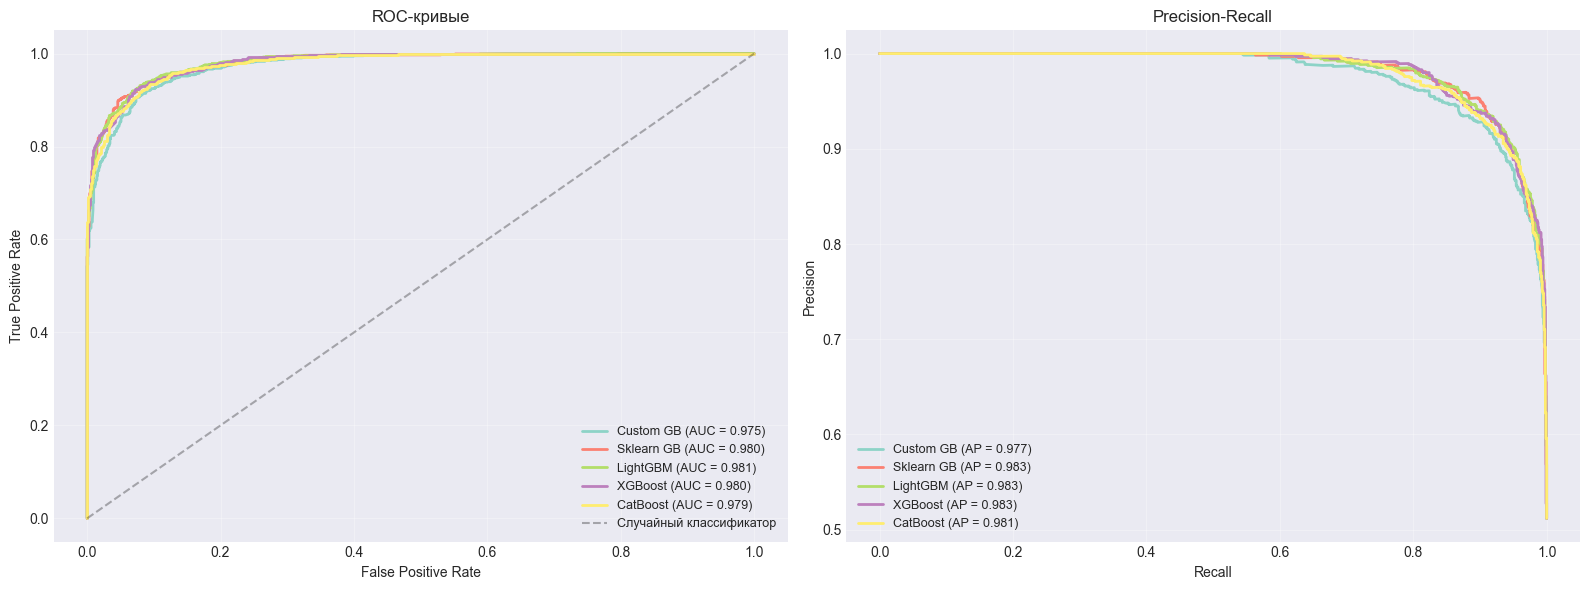

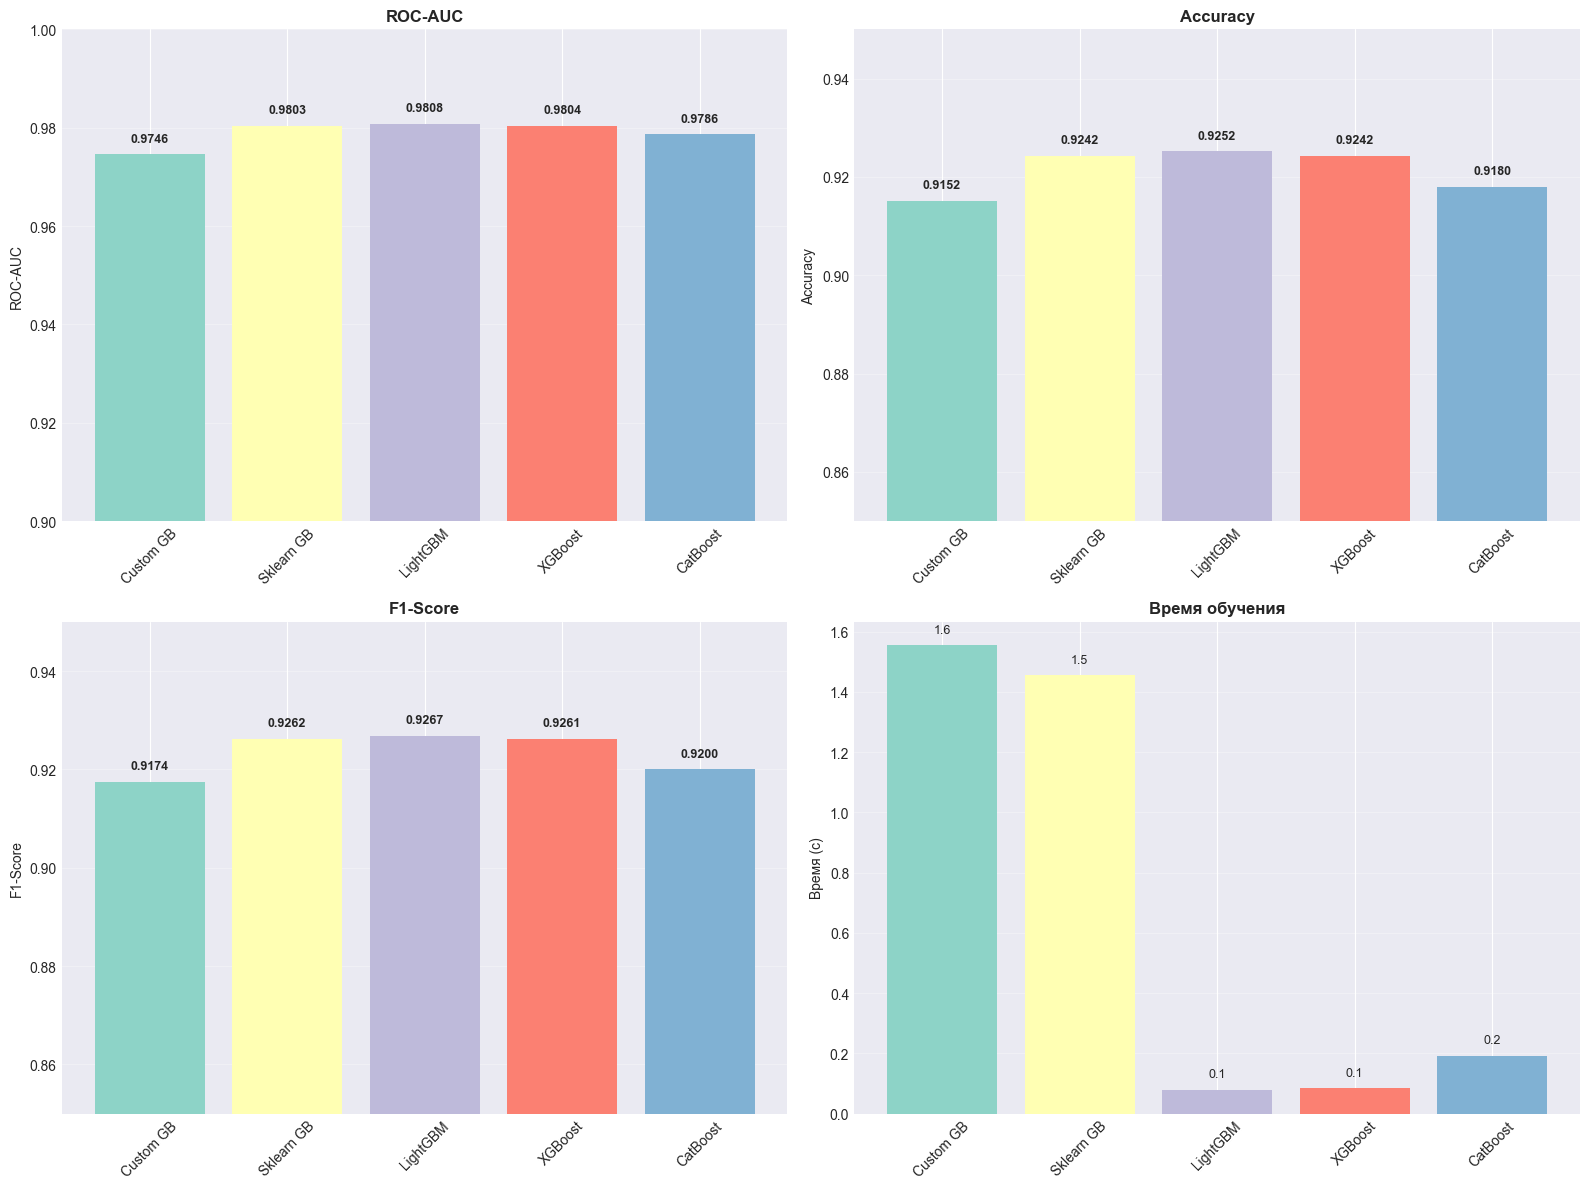

In [50]:
models_predictions = {
    'Custom GB': (y_val_split, y_pred_proba_fixed_gb),
    'Sklearn GB': (y_val_split, y_pred_proba_sklearn_gb),
    'LightGBM': (y_val_split, y_pred_proba_lgb),
    'XGBoost': (y_val_split, y_pred_proba_xgb),
    'CatBoost': (y_val_split, y_pred_proba_catboost)
}

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
colors = plt.cm.Set3(np.linspace(0, 1, len(models_predictions)))

for (name, (y_true, y_pred_proba)), color in zip(models_predictions.items(), colors):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc_score = roc_auc_score(y_true, y_pred_proba)
    ax.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})', 
            linewidth=2, color=color)

ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Случайный классификатор')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC-кривые')
ax.legend(loc='lower right', fontsize=9)
ax.grid(True, alpha=0.3)

ax = axes[1]
for (name, (y_true, y_pred_proba)), color in zip(models_predictions.items(), colors):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    auc_pr = average_precision_score(y_true, y_pred_proba)
    ax.plot(recall, precision, label=f'{name} (AP = {auc_pr:.3f})', 
            linewidth=2, color=color)

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall')
ax.legend(loc='lower left', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_summary = pd.DataFrame({
    'Model': ['Custom GB', 'Sklearn GB', 'LightGBM', 'XGBoost', 'CatBoost'],
    'Accuracy': [fixed_gb_acc, sklearn_gb_acc, lgb_acc, xgb_acc, catboost_acc],
    'ROC-AUC': [fixed_gb_auc, sklearn_gb_auc, lgb_auc, xgb_auc, catboost_auc],
    'F1-Score': [
        fixed_gb_f1, 
        f1_score(y_val_split, y_pred_sklearn_gb),
        f1_score(y_val_split, y_pred_lgb),
        f1_score(y_val_split, y_pred_xgb),
        f1_score(y_val_split, y_pred_catboost)
    ],
    'Time (s)': [fixed_gb_time, sklearn_gb_time, lgb_time, xgb_time, catboost_time]
})

ax = axes[0, 0]
bars1 = ax.bar(metrics_summary['Model'], metrics_summary['ROC-AUC'], 
               color=plt.cm.Set3(np.arange(len(metrics_summary))))
ax.set_title('ROC-AUC', fontsize=12, fontweight='bold')
ax.set_ylabel('ROC-AUC')
ax.set_ylim([0.9, 1.0])
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars1, metrics_summary['ROC-AUC']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.002,
           f'{value:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax = axes[0, 1]
bars2 = ax.bar(metrics_summary['Model'], metrics_summary['Accuracy'],
               color=plt.cm.Set3(np.arange(len(metrics_summary))))
ax.set_title('Accuracy', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.85, 0.95])
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars2, metrics_summary['Accuracy']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.002,
           f'{value:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax = axes[1, 0]
bars3 = ax.bar(metrics_summary['Model'], metrics_summary['F1-Score'],
               color=plt.cm.Set3(np.arange(len(metrics_summary))))
ax.set_title('F1-Score', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score')
ax.set_ylim([0.85, 0.95])
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars3, metrics_summary['F1-Score']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.002,
           f'{value:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax = axes[1, 1]
bars4 = ax.bar(metrics_summary['Model'], metrics_summary['Time (s)'],
               color=plt.cm.Set3(np.arange(len(metrics_summary))))
ax.set_title('Время обучения', fontsize=12, fontweight='bold')
ax.set_ylabel('Время (с)')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars4, metrics_summary['Time (s)']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + max(metrics_summary['Time (s)'])*0.02,
           f'{value:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Подбор гиперпараметров с Optuna

In [51]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20)
    }
    
    if best_model_name == "LightGBM":
        params['num_leaves'] = trial.suggest_int('num_leaves', 20, 100)
        model = lgb.LGBMClassifier(**params, random_state=42, verbosity=-1, n_jobs=-1)
    elif best_model_name == "XGBoost":
        params['gamma'] = trial.suggest_float('gamma', 0, 5)
        model = xgb.XGBClassifier(**params, random_state=42, eval_metric='logloss', 
                                 use_label_encoder=False, n_jobs=-1)
    elif best_model_name == "CatBoost":
        model = CatBoostClassifier(**params, random_state=42, verbose=False, thread_count=-1)
    else:
        model = GradientBoostingClassifier(**params, random_state=42)
    
    cv_scores = cross_val_score(
        model, X_train_reduced, y_train_split.values,
        cv=3, scoring='roc_auc', n_jobs=-1
    )
    
    return cv_scores.mean()

print("Начинаем оптимизацию гиперпараметров...")
study = optuna.create_study(
    direction='maximize',
    study_name='gradient_boosting_optimization',
    sampler=optuna.samplers.TPESampler(seed=42)
)

study.optimize(objective, n_trials=30, show_progress_bar=True)

print("\nРезультаты оптимизации:")
print(f"  Лучшее значение ROC-AUC: {study.best_value:.4f}")
print(f"  Лучшие гиперпараметры:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")

print(f"\nОбучение лучшей модели с оптимизированными параметрами...")

if best_model_name == "LightGBM":
    best_model = lgb.LGBMClassifier(**study.best_params, random_state=42, verbosity=-1, n_jobs=-1)
elif best_model_name == "XGBoost":
    best_model = xgb.XGBClassifier(**study.best_params, random_state=42, 
                                  eval_metric='logloss', use_label_encoder=False, n_jobs=-1)
elif best_model_name == "CatBoost":
    best_model = CatBoostClassifier(**study.best_params, random_state=42, verbose=False, thread_count=-1)
else:
    best_model = GradientBoostingClassifier(**study.best_params, random_state=42)

best_model.fit(X_train_reduced, y_train_split.values)

y_pred_best = best_model.predict(X_val_reduced)
y_pred_proba_best = best_model.predict_proba(X_val_reduced)[:, 1]

best_auc = roc_auc_score(y_val_split, y_pred_proba_best)
best_acc = accuracy_score(y_val_split, y_pred_best)

print(f"\nРезультаты оптимизированной модели:")
print(f"  ROC-AUC: {best_auc:.4f}")
print(f"  Accuracy: {best_acc:.4f}")

[I 2025-12-14 17:35:04,660] A new study created in memory with name: gradient_boosting_optimization


Начинаем оптимизацию гиперпараметров...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-14 17:35:09,202] Trial 0 finished with value: 0.9817932901336065 and parameters: {'n_estimators': 87, 'learning_rate': 0.4123206532618726, 'max_depth': 7, 'subsample': 0.7993292420985183, 'min_samples_split': 4, 'num_leaves': 32}. Best is trial 0 with value: 0.9817932901336065.
[I 2025-12-14 17:35:12,249] Trial 1 finished with value: 0.9825047636135112 and parameters: {'n_estimators': 30, 'learning_rate': 0.29621516588303487, 'max_depth': 6, 'subsample': 0.8540362888980227, 'min_samples_split': 2, 'num_leaves': 98}. Best is trial 1 with value: 0.9825047636135112.
[I 2025-12-14 17:35:15,110] Trial 2 finished with value: 0.9796199388046615 and parameters: {'n_estimators': 170, 'learning_rate': 0.022948683681130556, 'max_depth': 3, 'subsample': 0.5917022549267169, 'min_samples_split': 7, 'num_leaves': 62}. Best is trial 1 with value: 0.9825047636135112.
[I 2025-12-14 17:35:16,603] Trial 3 finished with value: 0.9816534961856656 and parameters: {'n_estimators': 98, 'learning_rat

### Создание результирующего файла

In [57]:
print("\nПодготовка данных...")
X_train_final = pd.concat([X_train_split, X_val_split], axis=0)
y_train_final = pd.concat([y_train_split, y_val_split], axis=0)
print(f"Финальный тренировочный набор: {X_train_final.shape}")

print("\nОбучение лучшей модели на всех данных...")
best_model.fit(X_train_final, y_train_final)
print("Обучение завершено")

print("\nПредсказание для тестовых данных...")
test_predictions_proba = best_model.predict_proba(X_test)[:, 1]
test_predictions_binary = (test_predictions_proba >= 0.5).astype(int)

print(f"Получено {len(test_predictions_binary)} предсказаний")

print("\nОценка качества модели:")
cv_scores = cross_val_score(
    best_model, X_train_final, y_train_final,
    cv=5, scoring='roc_auc', n_jobs=-1
)

print("\nСоздание ex файла...")
ex_df = pd.DataFrame({
    'ID': test_ids,
    'LoanApproved': test_predictions_binary
})

ex_file = 'ex.csv'
ex_df.to_csv(ex_file, index=False)

print(f"\nФайл {ex_file} сохранен")


Подготовка данных...
Финальный тренировочный набор: (10487, 34)

Обучение лучшей модели на всех данных...
Обучение завершено

Предсказание для тестовых данных...
Получено 5000 предсказаний

Оценка качества модели:

Создание ex файла...

Файл ex.csv сохранен
